# SBRC2022

<div align="justify"> O objetivo deste notebook é apresentar exemplos de utilização de modelos de Aprendizado de Máquina aplicado aos problemas de redes de computadores. Iremos tratar especificamente de Detecção de DDoS. Para isto iremos utilizar a linguagem Python com as bibliotecas NumPy, Pandas e Scikit learn. </div>

Esse Notebook aboradará os seguintes passos:
    <ul>
    <li>Preparação dos Dados</li>
    <li>Definição das Classes</li>
    <li>Classificação com Modelos AM</li>
    <li>Conclusão</li>



## Conectar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls 'drive/MyDrive/Doutorado/Minicurso'

'Classificação de Tráfego.ipynb'
'Classifications_Models-Rolling Windows.ipynb'
'Cópia de Classificação de Tráfego.ipynb'
 dataset_classificacao.csv
 dataset_sdn.csv
 Detecção_Anomalia.ipynb
 Detecção_DDoS.ipynb
'Exemplo Classificação de Tráfego.ipynb'
 filtered_dataset_classificacao.csv
 modelo.mlp
 Untitled0.ipynb


In [3]:
path_dataset = 'drive/MyDrive/Doutorado/Minicurso/dataset_sdn.csv'
path_dataset_filtered = 'drive/MyDrive/Doutorado/Minicurso/filtered_dataset_sdn.csv'
path_model_ddos = 'drive/MyDrive/Doutorado/Minicurso/modelo_ddos.mlp'

## Importar Bibliotecas

In [4]:
#libraries for data manipulation
import numpy as np
import pandas as pd

#Models for Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


#libraries for selecting features and parameters
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#libraries for validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

#libraries for graphics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time


In [83]:
from sklearn.multioutput import MultiOutputClassifier

In [86]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

## Preparação dos Dados

### Carregar Dataset

In [66]:
df = pd.read_csv(path_dataset, sep=',')

In [67]:
df

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


### Visualizar os Dados

In [68]:
#view of columns 
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [70]:
df.isna().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [71]:
df = df.dropna()

In [72]:
df.label.value_counts()

0    63335
1    40504
Name: label, dtype: int64

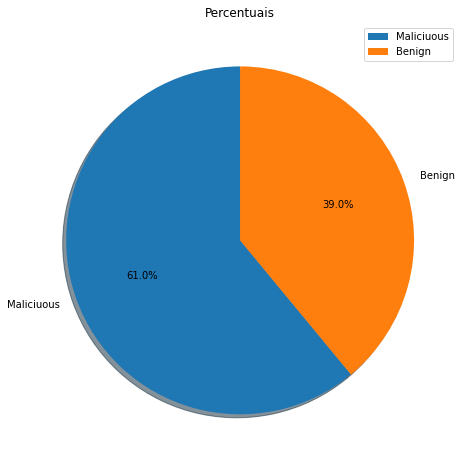

In [73]:
labels = ["Maliciuous",'Benign']
sizes = [dict(df.label.value_counts())[0], dict(df.label.value_counts())[1]]
plt.figure(figsize = (13,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(["Maliciuous", "Benign"])
plt.title('Percentuais')
plt.show()

## Definição das Classes

In [74]:
encoder = LabelEncoder()

In [75]:
target=encoder.fit_transform(df['label'])

In [76]:
x = df.drop(['dt','src','dst','tot_dur','rx_kbps','tot_kbps'], axis=1)
y = df.label

In [77]:
df

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,...,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [78]:
x = pd.get_dummies(x)

In [79]:
x

,switch,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,label,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,1,45304,48294064,100,716000000,3,1943,13535,14428310,451,0,3,143928631,3917,0,0,0,0,1
1,1,126395,134737070,280,734000000,2,1943,13531,14424046,451,0,4,3842,3520,0,0,0,0,1
2,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,1,3795,1242,0,0,0,0,1
3,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,2,3688,1492,0,0,0,0,1
4,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,3,3413,3665,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,3,79,7742,81,842000000,5,10,29,2842,0,0,1,15209,12720,1,0,1,0,0
104341,3,79,7742,81,842000000,5,10,29,2842,0,0,3,15099,14693,1,0,1,0,0
104342,3,31,3038,31,805000000,5,10,30,2940,1,0,2,3409,3731,0,0,1,0,0
104343,3,31,3038,31,805000000,5,10,30,2940,1,0,1,15209,12720,1,0,1,0,0


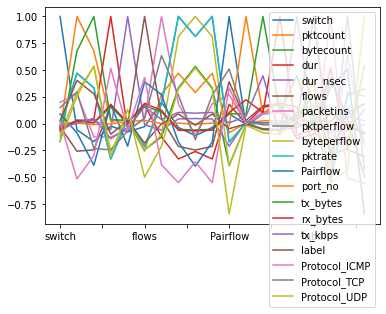

In [80]:
x.corr().plot()

In [81]:
x.corr()['label']

switch           0.027644
pktcount         0.403217
bytecount        0.278051
dur             -0.098734
dur_nsec         0.029161
flows           -0.181510
packetins       -0.002489
pktperflow       0.089608
byteperflow     -0.014160
pktrate          0.089801
Pairflow        -0.047474
port_no         -0.002759
tx_bytes        -0.049302
rx_bytes        -0.056578
tx_kbps         -0.005646
label            1.000000
Protocol_ICMP   -0.270212
Protocol_TCP     0.104440
Protocol_UDP     0.182842
Name: label, dtype: float64

In [82]:
x = x.drop(['label'], axis=1)

### Criar conjunto Alvo

In [ ]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104340    0
104341    0
104342    0
104343    0
104344    0
Name: label, Length: 103839, dtype: int64

In [ ]:
y.describe()

count    103839.000000
mean          0.390065
std           0.487767
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [85]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3)

In [102]:
np.any(np.isnan(x_treino))

False

In [103]:
np.all(np.isfinite(x_treino))

True

In [104]:
x_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72687 entries, 66287 to 85702
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   switch         72687 non-null  int64
 1   pktcount       72687 non-null  int64
 2   bytecount      72687 non-null  int64
 3   dur            72687 non-null  int64
 4   dur_nsec       72687 non-null  int64
 5   flows          72687 non-null  int64
 6   packetins      72687 non-null  int64
 7   pktperflow     72687 non-null  int64
 8   byteperflow    72687 non-null  int64
 9   pktrate        72687 non-null  int64
 10  Pairflow       72687 non-null  int64
 11  port_no        72687 non-null  int64
 12  tx_bytes       72687 non-null  int64
 13  rx_bytes       72687 non-null  int64
 14  tx_kbps        72687 non-null  int64
 15  Protocol_ICMP  72687 non-null  uint8
 16  Protocol_TCP   72687 non-null  uint8
 17  Protocol_UDP   72687 non-null  uint8
dtypes: int64(15), uint8(3)
memory usage: 9.1 M

## Classificação com Modelos AM

### Kmeans

In [87]:
kmeans = KMeans(n_clusters=8, random_state=42).fit(x_treino)

In [89]:
x_test_clusters=kmeans.predict(x_teste)
x_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(x_teste.values,x_test_clusters_centers[x_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

In [91]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

In [92]:
roc_auc_score(y_teste, km_y_pred)

0.5026518707007178

In [95]:
f1_score(y_teste, km_y_pred)

0.0944597135831043

In [97]:
km_cm=confusion_matrix(y_teste, km_y_pred)

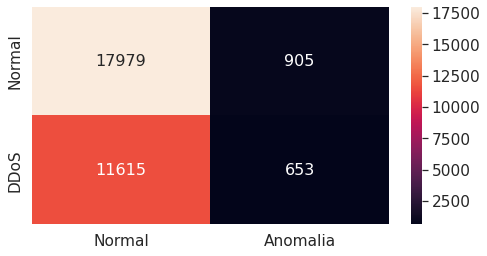

In [101]:
df_cm = pd.DataFrame(km_cm,
                  ['Normal','DDoS'],['Normal','Anomalia'])
plt.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font si

# Conclusão

<div align="justify">Foi realizada a detecção de DDoS utilizando modelos de AM para exemplificação do minicurso apresentado no SRBC 2022. </div>


# Referências

<div>[1] https://www.kaggle.com/code/aikenkazin/ddos-attack-detection-classification/data.</div>